In [1]:
!pip install -U opencv-python
!apt-get upgrade
!apt update && apt install -y libsm6 libxext6 ffmpeg libfontconfig1 libxrender1 libgl1-mesa-glx

/bin/sh: apt-get: command not found
/bin/sh: apt: command not found


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

print(np.__version__)
print(tf.__version__)
print(cv2.__version__)

1.18.5
2.3.1
4.5.2


In [3]:
def load_data(path):
    high_res_images = []
    low_res_images = []
    for dirname, _, filenames in os.walk(path+'high_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            img = process_image(img)
            high_res_images.append(img)
        
    for dirname, _, filenames_2 in os.walk(path+'low_res'):
        for filename in filenames_2:
            if filename in filenames: # check for non-present images
                img = cv2.imread(os.path.join(dirname, filename))
                img = process_image(img)
                low_res_images.append(img)
    
    # zero-mean and zero-center the standard deviations ....
    low_res_array = np.array(low_res_images)
    #mean_centered_low_res = (low_res_array - low_res_array.mean())/low_res_array.std()
    
    # zero-mean and zero-center the standard deviations .....
    high_res_array = np.array(high_res_images)
    #mean_centered_high_res = (high_res_array - high_res_array.mean())/high_res_array.std()
    
    
    #return mean_centered_low_res, mean_centered_high_res
    return low_res_array,high_res_array

def process_image(image):
    return image/255

In [4]:
base_dir = ''
train_x, train_y =  load_data(base_dir+'train/')
val_x, val_y = load_data(base_dir+'val/')

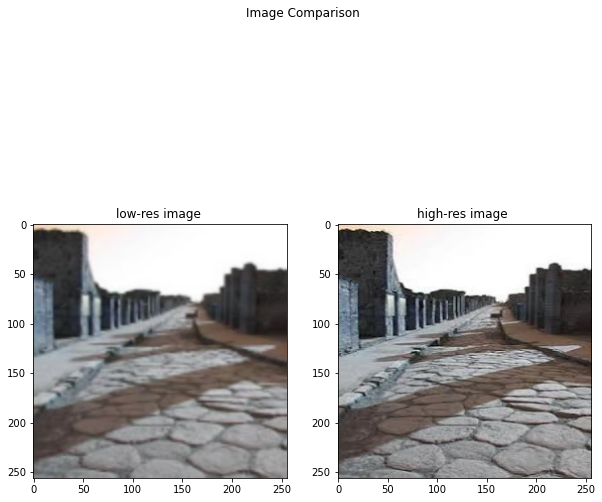

In [5]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
fig.suptitle('Image Comparison')
ax1.imshow(train_x[1])
ax1.title.set_text("low-res image ")
ax2.imshow(train_y[1])
ax2.title.set_text("high-res image ")

In [6]:
# Model Number 3 with batch normalization to go 2 levels deeper in expressiveness
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 64
input_shape = (256,256,3)

encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
#x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
#x = layers.Reshape((7, 7, 64))(x)
#x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
#x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
#decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(64 * 64 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((64, 64, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
#decoder_outputs = tf.slice(decoder_outputs, begin=[0, 0, 0, 0], size=[tf.shape(decoder_outputs)[0], 28, 28, 1])

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

@tf.function
def psnr_loss(input_img, decoded): 
    #y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    #input_img = tf.cast(input_img, tf.float32)
    #decoded = tf.cast(decoded, tf.float32)
    #return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    
    #max_pixel = 255
    # loss = -(10.0 * tf.log((tf.reduce_mean(tf.square(input_img - decoded), axis=1)))) / 2.303
    #loss_mse = tf.keras.losses.mean_squared_error(input_img, decoded) 
    #return loss_mse  + tf.image.psnr(input_img, decoded, max_val=1)
    
    psnr = tf.image.psnr(input_img, tf.clip_by_value(decoded, clip_value_min=0., clip_value_max=1.), max_val=1)
    return tf.reduce_mean(psnr)
    
    #input_img = tf.cast(input_img, tf.float32)
    #return tf.reduce_mean(input_img - decoded)
    # return tf.reduce_mean(max_pixel_value / tf.squre(input_img - decoder))

class VAE(keras.Model):
    
    
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #reconstruction_loss = tf.reduce_mean(
            #    tf.reduce_sum(
            #        keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2)
            #    )
            mse = tf.keras.losses.MeanSquaredError()
            #reconstruction_loss = tf.reduce_mean(tf.reduce_mean(tf.square(data - reconstruction), axis=(1, 2, 3,)), axis=(0))
            reconstruction_loss = mse(data, reconstruction)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
#data = train_x[np.arange(1)].copy() / 255
#data = np.expand_dims(data, -1).astype("float32") 
#if len(data.shape) == 5:
#    data = data.squeeze()
#if len(data.shape) == 3:
#    data = data[np.newaxis, :, :, :]

#print (data.shape)
# x_train.shape
model = VAE(encoder, decoder)
model.compile(optimizer=keras.optimizers.Adam(), loss=None)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  73856       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
def train(model, train_x, train_y, epochs = 1, batch_size = 32, shuffle = False):
    return model.fit(train_x, train_y,epochs=epochs,batch_size=batch_size,shuffle=shuffle, validation_data=(val_x, val_y))

In [11]:
history = train(model, train_x, train_y, epochs = 10, batch_size = 10, shuffle = True)

Epoch 1/10
69/69 [==============================] - 30s 428ms/step - loss: 0.0854 - reconstruction_loss: 0.0822 - kl_loss: 2.7145e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/10
69/69 [==============================] - 29s 424ms/step - loss: 0.0795 - reconstruction_loss: 0.0812 - kl_loss: 1.2315e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/10
69/69 [==============================] - 29s 423ms/step - loss: 0.0822 - reconstruction_loss: 0.0814 - kl_loss: 6.3910e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/10
69/69 [==============================] - 29s 426ms/step - loss: 0.0814 - reconstruction_loss: 0.0814 - kl_loss: 3.7299e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/10
69/69 [==============================] - 29s 424ms/step - loss: 0.0807 - reconstr

In [12]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

# This class creates a scmple given a mean and variance - assuming a Gaussian distribution
##########################################################################################
##########################################################################################
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
##########################################################################################
##########################################################################################

latent_dim = 64
input_shape = (256, 256, 3)

encoder_inputs = keras.Input(shape=input_shape)  
l1 = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs) # input shape 256,256,3
l2 = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(l1) #input shape 128,128,64
l3 = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(l2) # 64,64,64
l4 = layers.Flatten()(l3)
l5 = layers.Dense(256, activation="relu")(l4) # best if this dimension is greater than the latent_dim simension
z_mean = layers.Dense(latent_dim, name="z_mean")(l5)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(l5)
z = Sampling()([z_mean, z_log_var])
#encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
#encoder.summary()

#latent_inputs = keras.Input(shape=(latent_dim,))

#l6 = layers.Dense(64 * 64 * 64, activation="relu")(latent_inputs)
l6 = layers.Dense(64 * 64 * 64, activation="relu")(z)
l7 = layers.Reshape((64, 64, 64))(l6) #shape is 64,64,64
l8 = layers.add([l2,l7])
l9 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(l8) #64,128,128
l10 = layers.add([l1,l9])
l11 = layers.Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(l10) #256,256,64

l12 = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(l11) #256,256,32
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="relu", padding="same")(l12) #256,256,3
#decoder_outputs = tf.slice(decoder_outputs, begin=[0, 0, 0, 0], size=[tf.shape(decoder_outputs)[0], 28, 28, 1])

decoder = keras.Model(encoder_inputs,[z_mean,z_log_var,decoder_outputs], name="decoder")
decoder.summary()


Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 64)   36928       conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 128)  73856       conv2d_4[0][0]                   
____________________________________________________________________________________________

In [13]:
optimizer = tf.keras.optimizers.Adam(1e-4)


In [17]:
class VAE(keras.Model):
    def __init__(self, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, data):
        z_mean, z_log_var, reconstruction = self.decoder(data)
        return reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            
            z_mean, z_log_var, reconstruction = self.decoder(data)
            #reconstruction = self.decoder(z)
            #reconstruction_loss = tf.reduce_mean(
            #    tf.reduce_sum(
            #        keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2)
            #    )
            
            #reconstruction_loss = tf.reduce_mean(tf.reduce_mean(tf.square(data - reconstruction), axis=(1, 2, 3,)), axis=(0))
            reconstruction_loss = tf.keras.losses.MSE(data, reconstruction)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = 0.001 *reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.decoder.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    

model = VAE(decoder)
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=None)

In [18]:
def train(model, train_x, train_y, epochs = 1, batch_size = 32, shuffle = False):
    return model.fit(train_x, train_y,epochs=epochs,batch_size=batch_size,shuffle=shuffle, validation_data=(val_x, val_y))

In [19]:
history = train(model, train_x, train_y, epochs = 20, batch_size = 10, shuffle = True)

Epoch 1/20
69/69 [==============================] - 40s 579ms/step - loss: 1.2365e-06 - reconstruction_loss: 0.0011 - kl_loss: 1.0366e-08 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/20
69/69 [==============================] - 40s 573ms/step - loss: 1.0061e-06 - reconstruction_loss: 0.0010 - kl_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/20
69/69 [==============================] - 39s 572ms/step - loss: 9.6851e-07 - reconstruction_loss: 9.9461e-04 - kl_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/20
69/69 [==============================] - 39s 568ms/step - loss: 9.9119e-07 - reconstruction_loss: 9.7023e-04 - kl_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/20
69/69 [==============================] - 40s 576ms/step -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


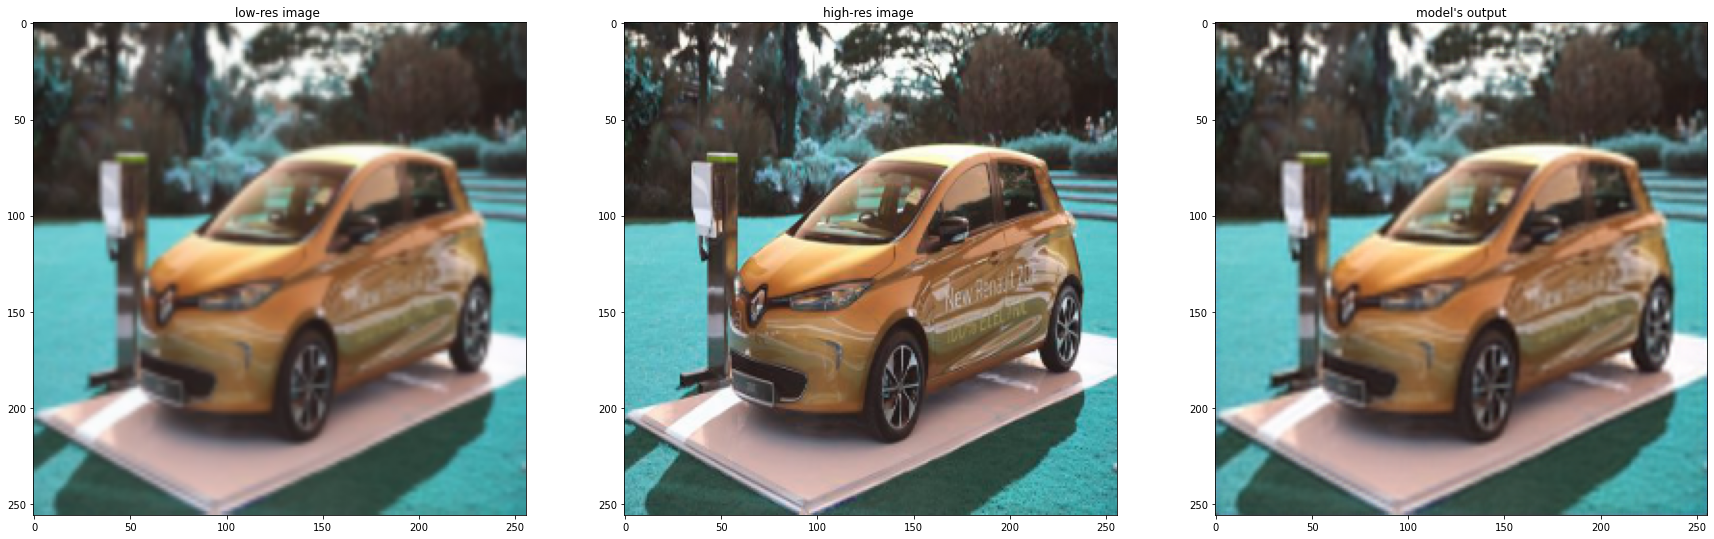

<Figure size 2880x2880 with 0 Axes>

In [23]:
val_pred= model.predict(val_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[1])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[1])
ax2.title.set_text("high-res image ")
ax3.imshow(val_pred[1])
ax3.title.set_text("model's output")

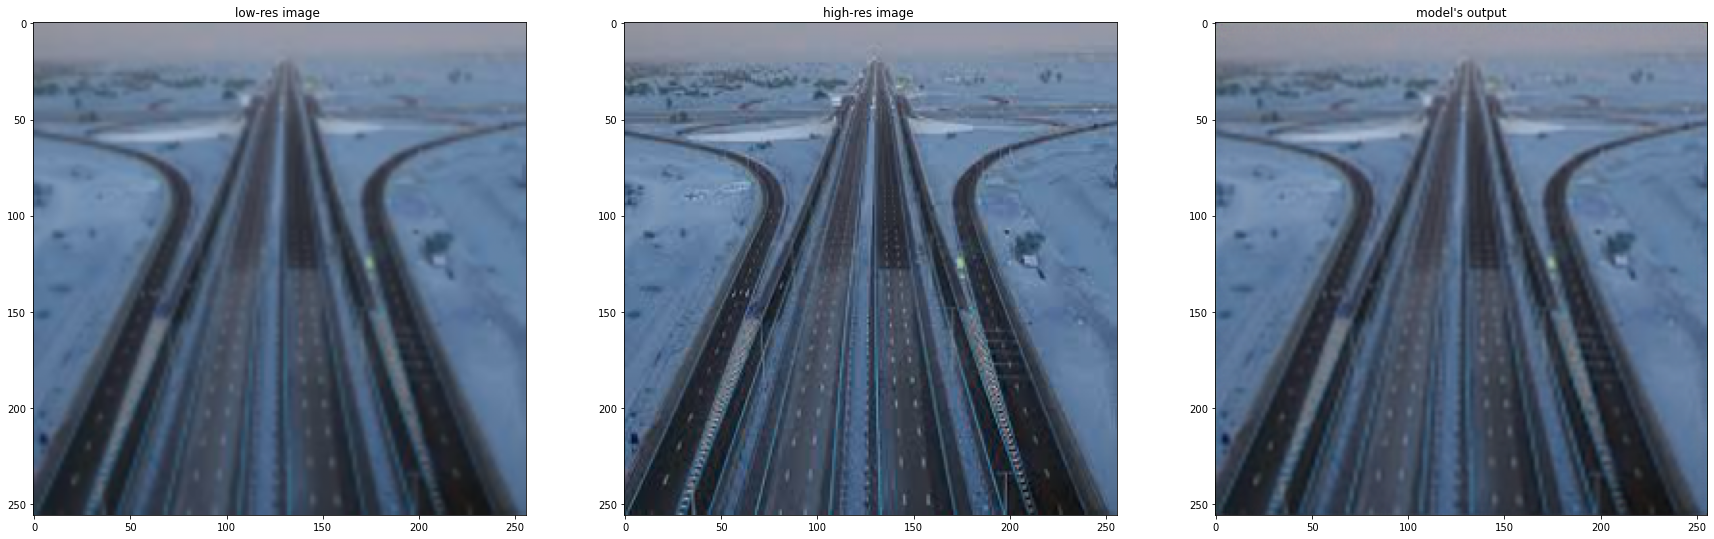

<Figure size 2880x2880 with 0 Axes>

In [24]:
#val_pred= model.predict(val_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[12])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[12])
ax2.title.set_text("high-res image ")
ax3.imshow(val_pred[12])
ax3.title.set_text("model's output")